# Part 1: Performance Measurement

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.optimize as optimize

In [2]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.facecolor'] = '1.'

In [3]:
IndPtf = pd.read_excel('Industry_Portfolios.xlsx')
IndPtf['Date'] = pd.to_datetime(IndPtf['Date'], format = '%Y%m')
IndPtf = IndPtf.set_index('Date')

RiskFactor = pd.read_excel('Risk_factors.xlsx')
RiskFactor['Date'] = pd.to_datetime(RiskFactor['Date'], format = '%Y%m')
RiskFactor = RiskFactor.set_index('Date')

In [4]:
print(RiskFactor.shape)
RiskFactor.head()

(120, 4)


,Rf,Rm-Rf,SMB,HML
Date,,,,
2004-01-01,0.07,2.15,2.67,1.55
2004-02-01,0.06,1.40,-1.17,0.45
2004-03-01,0.09,-1.32,1.84,0.07
2004-04-01,0.08,-1.83,-2.59,-1.67
2004-05-01,0.06,1.17,-0.10,-0.33


In [5]:
print(IndPtf.shape)
IndPtf.head()

(120, 10)


,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
Date,,,,,,,,,,
2004-01-01,0.06,-1.07,-0.62,0.44,4.53,1.41,0.45,3.09,1.92,2.88
2004-02-01,4.25,-0.07,1.95,4.69,-2.92,-0.52,6.09,0.89,2.07,2.16
2004-03-01,-0.09,-1.15,-0.27,-0.13,-2.55,-2.07,0.29,-3.96,1.13,-0.63
2004-04-01,1.42,2.30,-0.17,2.52,-4.91,-0.48,-2.70,3.54,-3.55,-3.76
2004-05-01,-1.89,-1.64,1.61,0.39,4.85,-2.95,0.30,-0.42,1.28,1.86


In [6]:
ExcRet = IndPtf.sub(RiskFactor['Rf'], axis =0)

ExcRet.head()

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
Date,,,,,,,,,,
2004-01-01,-0.01,-1.14,-0.69,0.37,4.46,1.34,0.38,3.02,1.85,2.81
2004-02-01,4.19,-0.13,1.89,4.63,-2.98,-0.58,6.03,0.83,2.01,2.10
2004-03-01,-0.18,-1.24,-0.36,-0.22,-2.64,-2.16,0.20,-4.05,1.04,-0.72
2004-04-01,1.34,2.22,-0.25,2.44,-4.99,-0.56,-2.78,3.46,-3.63,-3.84
2004-05-01,-1.95,-1.70,1.55,0.33,4.79,-3.01,0.24,-0.48,1.22,1.80


## Sharpe Ratio

In [7]:
Data = pd.DataFrame()
Data['Sharpe Ratio'] = ExcRet.apply(lambda x: ( x.mean() )/( x.std() ))

## Sortino Ratio

In [8]:
SV= ExcRet.apply(lambda x: np.square( x.apply(lambda y: min(y, 0)) ).mean() )
Data['Sortino Ratio'] = ExcRet.apply(lambda x: x.mean() ) / np.sqrt(SV)

## Jensen's Alpha

In [9]:
def calculate_CAPM(Rm_Rf, Ri_Rf):
    ''' calculate Alpha and Beta for CAPM
    input:
    --- Rm_Rf: series of market portfolio excess return
                pandas.core.series.Series type
                
    --- Ri_Rf: series of i_th portfolio excess return
                 pandas.core.series.Series type
             
    output:
    --- result.params: OLS parameters
                                pandas.core.series.Series type
    
    '''
    X = sm.add_constant(Rm_Rf)
    y = Ri_Rf
    results = sm.OLS(y, X).fit()

    return results.params

CAPM = pd.concat([calculate_CAPM(RiskFactor['Rm-Rf'], ExcRet[name])
                  for name in ExcRet.columns], axis = 1)

CAPM

,0,1,2,3,4,5,6,7,8,9
const,0.369717,-0.417903,0.160494,0.504485,-0.064024,0.194348,0.274093,0.236968,0.446523,-0.387508
Rm-Rf,0.653744,1.649374,1.167929,0.965527,1.132387,0.901721,0.829515,0.675890,0.537009,1.206992


In [10]:
Data['Jensen\'s Alpha'] = CAPM.loc['const', :].values

## 3-factor alpha

In [11]:
def calculate_3_FACTOR(Rx_Rf, Ri_Rf):
    ''' calculate Alpha and Beta for three-factor model
    input:
    --- Rx_Rf: series of explanatory factors
                pandas.core.series.Series type
                
    --- Ri_Rf: series of i_th portfolio excess return
                 pandas.core.series.Series type
             
    output:
    --- result.params: OLS parameters
                                pandas.core.series.Series type
    
    '''
    X = sm.add_constant(Rx_Rf)
    y = Ri_Rf
    results = sm.OLS(y, X).fit()

    return results.params

THREE_FACTOR = pd.concat([calculate_3_FACTOR(RiskFactor.iloc[:, 1:], ExcRet[name]) 
                          for name in ExcRet.columns], axis = 1)

THREE_FACTOR

,0,1,2,3,4,5,6,7,8,9
const,0.386704,-0.474342,0.153285,0.523007,-0.065979,0.200724,0.255941,0.257472,0.474411,-0.404412
Rm-Rf,0.712134,1.447452,1.142282,1.028354,1.152803,0.924137,0.770227,0.751976,0.631827,1.123473
SMB,-0.229102,0.670878,0.087388,-0.259360,0.335674,-0.080299,0.280191,-0.212655,-0.387961,-0.061676
HML,-0.023342,0.240949,0.027727,-0.008158,-0.556947,-0.019063,-0.039080,-0.143765,-0.016881,0.547325


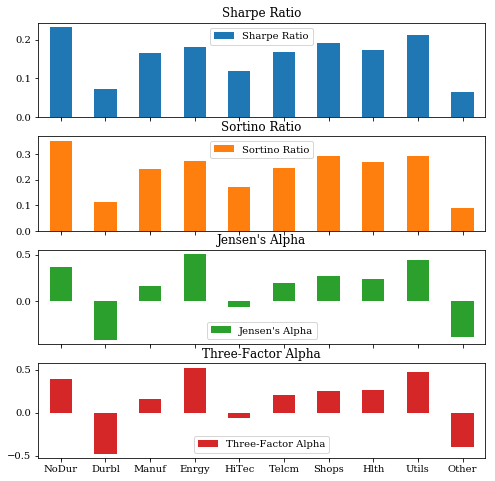

In [12]:
Data['Three-Factor Alpha'] = THREE_FACTOR.loc['const', :].values

Data.plot.bar(figsize = (8, 2*Data.shape[1]), rot=0, subplots=True)
plt.show()

In [13]:
Data.T

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
Sharpe Ratio,0.231099,0.072356,0.166616,0.181708,0.118552,0.169064,0.191753,0.172529,0.210948,0.064693
Sortino Ratio,0.350804,0.111967,0.241260,0.273612,0.170620,0.244940,0.293032,0.270294,0.290044,0.087351
Jensen's Alpha,0.369717,-0.417903,0.160494,0.504485,-0.064024,0.194348,0.274093,0.236968,0.446523,-0.387508
Three-Factor Alpha,0.386704,-0.474342,0.153285,0.523007,-0.065979,0.200724,0.255941,0.257472,0.474411,-0.404412


Sharpe ratio measures the risk premium per unit of total risk;

Sortino Ratio measures the risk premium per unit of downside risk;

Jensen's Alpha measures the pricing error of CAPM;

Three-factor Alpha measures the pricing error of three-factor model.

# Part 2: Minimum-Variance Frontier Revisited

## Calculate efficient frontier via scipy.optimize.minimize

Before we apply Monte Carlo method, we firstly use scipy.optimize.minimize to find out the frontier portfolio weight.

In [14]:
# because this is a long-only portfolio, so possible return should be 
# no less than the smallest single asset return and no more than
# largest single asset return.
mu_lst = np.arange( IndPtf.mean().min(), IndPtf.mean().max(), 0.001)
w_lst = []
for mu in mu_lst:
    # aiming function that we're going to minimize
    f = lambda w: np.dot(IndPtf.values, w.T).std()
    
    # boundary of weight
    bnds = ((0,1),)*10
    
    # constaints of mean of return and sum of portfolio weight
    cons = ({'type': 'eq', 'fun': lambda w:  np.dot(IndPtf.values, w.T).mean() - mu},
           {'type': 'eq', 'fun': lambda w:  sum(w) - 1})
    
    # initialization
    w0 = ([0.1]*10)
    
    # minimize standard deviation
    w_lst.append(optimize.minimize(f, w0, method='SLSQP',
                                   bounds=bnds, constraints=cons,
                                  options={'maxiter': 10000000, 'ftol': 1e-06}).x)

In [15]:
# calculate the (annual) sigma for frontier portfolio
FrontierSigma = [np.dot(IndPtf.values, w.T).std() for w in w_lst]

# calculate the (annual) mean of return for frontier portfolio
FrontierMeanReturn = [np.dot(IndPtf.values, w.T).mean() for w in w_lst]

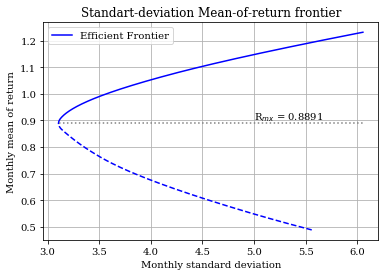

In [16]:
ind = FrontierSigma.index(min(FrontierSigma))

plt.plot(FrontierSigma[ind:], FrontierMeanReturn[ind:],
         '-', color = 'blue', label = 'Efficient Frontier')
plt.plot(FrontierSigma[:ind], FrontierMeanReturn[:ind],
         '--', color = 'blue')

plt.plot( [FrontierSigma[ind], max(FrontierSigma)], [FrontierMeanReturn[ind]]*2,
         ':', color = 'gray')
plt.text(5, FrontierMeanReturn[ind], 'R$%s$ = '%'_{mx}'\
         +str(round(FrontierMeanReturn[ind], 4)), verticalalignment='bottom')

plt.xlabel('Monthly standard deviation')
plt.ylabel('Monthly mean of return')
plt.title('Standart-deviation Mean-of-return frontier')
plt.legend(loc = 'best')
plt.grid(True)
plt.show()

In [17]:
w_ = np.array(w_lst)
w_ = w_.reshape(-1, 1)

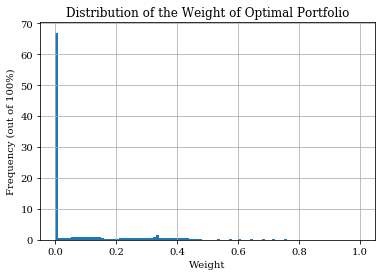

In [18]:
weight = np.ones(w_.shape)/len(w_)*100
plt.hist(w_, bins = 100, weights = weight)
plt.title('Distribution of the Weight of Optimal Portfolio')
plt.ylabel('Frequency (out of 100%)')
plt.xlabel('Weight')
plt.grid(True)
plt.show()

We can find that weight of optimal portfolio countains a great many extremely small value.

## Simulate efficient frontier via random weight generated by normal distribution

In [19]:
# Monte Carlo method

# random seed, keep the random number still
np.random.seed(101)

# numbers of random portfolio
n_portfolio =  int(1e6)

# generate random weight from normal distribution
w_normal = abs(np.random.randn(n_portfolio, 10))

# uncomment this line and comment the previous line if you want uniform distribution
#w_normal = np.random.rand(n_portfolio).reshape(-1, 10)

w_normal /= w_normal.sum(axis = 1, keepdims = True)
w_normal.shape

(1000000, 10)

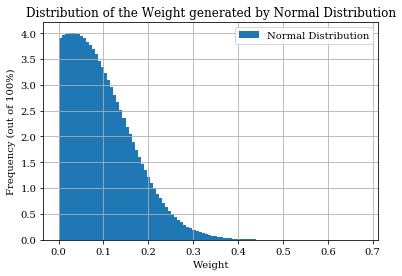

In [20]:
w_normal_ = w_normal.reshape(-1, 1)
weight = np.ones(w_normal_.shape)/w_normal_.shape[0]*100
plt.hist(w_normal_, bins = 100, weights = weight, label ='Normal Distribution')

plt.title('Distribution of the Weight generated by Normal Distribution')
plt.legend(loc = 'best')
plt.ylabel('Frequency (out of 100%)')
plt.xlabel('Weight')
plt.grid(True)
plt.show()

Weight generated from normal distribution are not very likely to located on the optimal portfolio, because it doesn't countain enough extremely weight.

In [21]:
# calculate sigma and mu for random portfolio
Portfolios = np.dot(IndPtf.values, w_normal.T)
Mean_normal = Portfolios.mean(axis = 0)
Std_normal = Portfolios.std(axis = 0)

In [22]:
# filter away points inside of the frontier
step = 0.1

ind_ = np.where(Std_normal == min(Std_normal) )
sigma = Std_normal[ind_][0]
sigma_normal = [sigma]
normal_line_upper = [ Mean_normal[ind_][0] ]
normal_line_lower = [ Mean_normal[ind_][0] ]

while sigma < max(Std_normal):
    sigma += step
    ind = ((Std_normal.reshape(-1,) >= sigma)  
               & (Std_normal.reshape(-1,) < sigma + step))
    
    while not ind.any() == True and  sigma < max(Std_normal):
        sigma += 0.1
        ind = ((Std_normal.reshape(-1,) >= sigma) 
               & (Std_normal.reshape(-1,) < sigma + step))
        
    if  ind.any() == True:
        sigma_normal.append(sigma)
        normal_line_upper.append(np.max(Mean_normal[ ind ]))
        normal_line_lower.append(np.min(Mean_normal[ ind ]))

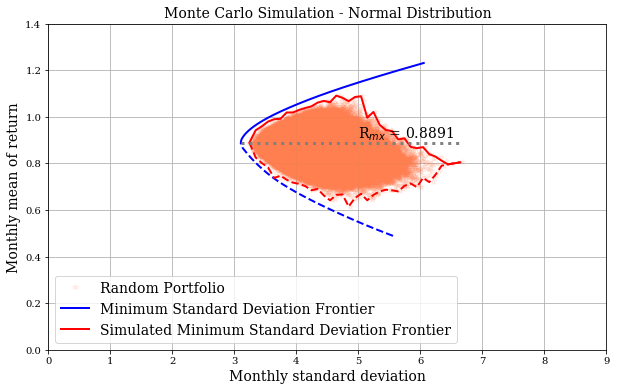

In [23]:
z = 2
fig = plt.figure(figsize = (z*5, z*3))

ind = FrontierSigma.index(min(FrontierSigma))
plt.plot(Std_normal, Mean_normal,
         '*', color = 'coral', alpha = 0.1, label = 'Random Portfolio')

plt.plot(FrontierSigma[ind:], FrontierMeanReturn[ind:], 
         '-', lw = z, color = 'blue', label = 'Minimum Standard Deviation Frontier')
plt.plot(FrontierSigma[:ind], FrontierMeanReturn[:ind],
         '--', lw = z, color = 'blue')

plt.plot(sigma_normal, normal_line_upper, 
         '-', lw = z, color = 'red', label = 'Simulated Minimum Standard Deviation Frontier')
plt.plot(sigma_normal, normal_line_lower,
         '--', lw = z, color = 'red')

plt.plot( [FrontierSigma[ind], max(Std_normal)], [FrontierMeanReturn[ind]]*2,
         ':', lw = 1.5*z, color = 'gray')
plt.text(5, FrontierMeanReturn[ind], 'R$%s$ = '%'_{mx}'\
         +str(round(FrontierMeanReturn[ind], 4)), verticalalignment='bottom', fontsize = 7*z)

plt.xlim(0, 9)
plt.ylim(0, 1.4)
plt.xlabel('Monthly standard deviation', fontsize = 7*z)
plt.ylabel('Monthly mean of return', fontsize = 7*z)
plt.title('Monte Carlo Simulation - Normal Distribution', fontsize = 7*z)
plt.grid(True)
plt.legend(loc = 'best', fontsize = 7*z)
plt.show()

No surprise, the simulation fails to be perfectly located on the frontier.

## Simulate efficient frontier via random weight generated by reciprocal normal distribution

In [24]:
# Monte Carlo method

# random seed, keep the random number still
np.random.seed(101)

# numbers of random portfolio
n_portfolio =  int(1e6)

# generate random weight from a reciprocal normal distribution
w_reciprocal = abs(1/np.random.randn(n_portfolio, 10))

w_reciprocal /= w_reciprocal.sum(axis = 1, keepdims = True)
w_reciprocal.shape

(1000000, 10)

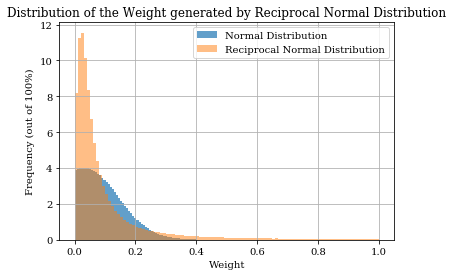

In [25]:
w_reciprocal_ = w_reciprocal.reshape(-1, 1)

plt.hist(w_normal_, bins = 100, weights = weight,
         alpha = 0.7, label ='Normal Distribution')
plt.hist(w_reciprocal_, bins = 100, weights = weight,
         alpha = 0.5, label ='Reciprocal Normal Distribution')

plt.title('Distribution of the Weight generated by Reciprocal Normal Distribution')
plt.legend(loc = 'best')
plt.ylabel('Frequency (out of 100%)')
plt.xlabel('Weight')
plt.grid(True)
plt.show()

A reciprocal of normal distribution can generate more extreme values than the original one.

In [26]:
# calculate sigma and mu for reciprocal random portfolio
Portfolios = np.dot(IndPtf.values, w_reciprocal.T)
Mean_reciprocal = Portfolios.mean(axis = 0)
Std_reciprocal = Portfolios.std(axis = 0)

In [27]:
# filter away points inside of the frontier
step = 0.1

ind_ = np.where(Std_reciprocal == min(Std_reciprocal) )
sigma = Std_reciprocal[ind_][0]
sigma_reciprocal = [sigma]
reciprocal_line_upper = [ Mean_reciprocal[ind_][0] ]
reciprocal_line_lower = [ Mean_reciprocal[ind_][0] ]

while sigma < max(Std_reciprocal):
    sigma += step
    ind = ((Std_reciprocal.reshape(-1,) >= sigma)  
               & (Std_reciprocal.reshape(-1,) < sigma + step))
    
    while not ind.any() == True and  sigma < max(Std_reciprocal):
        sigma += 0.1
        ind = ((Std_reciprocal.reshape(-1,) >= sigma) 
               & (Std_reciprocal.reshape(-1,) < sigma + step))
        
    if  ind.any() == True:
        sigma_reciprocal.append(sigma)
        reciprocal_line_upper.append(np.max(Mean_reciprocal[ ind ]))
        reciprocal_line_lower.append(np.min(Mean_reciprocal[ ind ]))

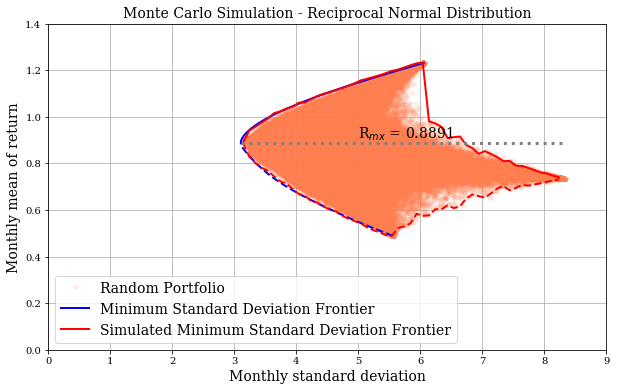

In [28]:
z = 2
fig = plt.figure(figsize = (z*5, z*3))

ind = FrontierSigma.index(min(FrontierSigma))
plt.plot(Std_reciprocal, Mean_reciprocal,
         '*', color = 'coral', alpha = 0.1, label = 'Random Portfolio')

plt.plot(FrontierSigma[ind:], FrontierMeanReturn[ind:], 
         '-', lw = z, color = 'blue', label = 'Minimum Standard Deviation Frontier')
plt.plot(FrontierSigma[:ind], FrontierMeanReturn[:ind],
         '--', lw = z, color = 'blue')

plt.plot(sigma_reciprocal, reciprocal_line_upper, 
         '-', lw = z, color = 'red', label = 'Simulated Minimum Standard Deviation Frontier')
plt.plot(sigma_reciprocal, reciprocal_line_lower,
         '--', lw = z, color = 'red')

plt.plot( [FrontierSigma[ind], max(Std_reciprocal)], [FrontierMeanReturn[ind]]*2,
         ':', lw = 1.5*z, color = 'gray')
plt.text(5, FrontierMeanReturn[ind], 'R$%s$ = '%'_{mx}'\
         +str(round(FrontierMeanReturn[ind], 4)), verticalalignment='bottom', fontsize = 7*z)

plt.xlim(0, 9)
plt.ylim(0, 1.4)
plt.xlabel('Monthly standard deviation', fontsize = 7*z)
plt.ylabel('Monthly mean of return', fontsize = 7*z)
plt.title('Monte Carlo Simulation - Reciprocal Normal Distribution', fontsize = 7*z)
plt.grid(True)
plt.legend(loc = 'best', fontsize = 7*z)
plt.show()

## Complementary Work : Uniform Distribution

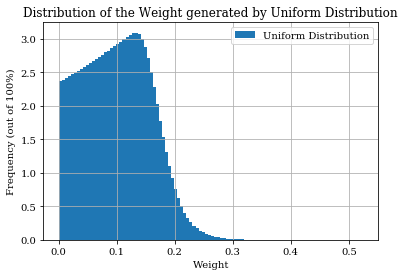

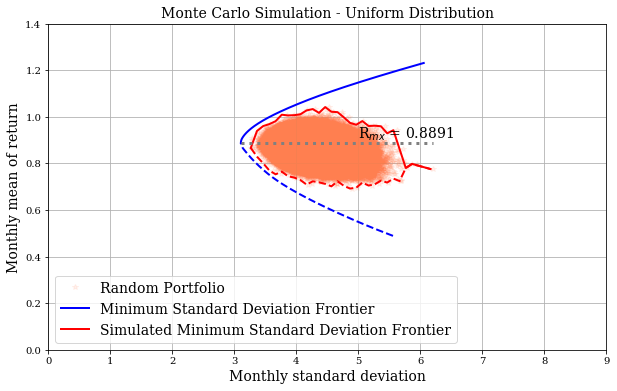

In [29]:
# Monte Carlo method
#############################################################
# random seed, keep the random number still
np.random.seed(101)

# numbers of random portfolio
n_portfolio =  int(1e6)

# generate random weight from uniform distribution
w_uniform = np.random.rand(n_portfolio, 10).reshape(-1, 10)

w_uniform /= w_uniform.sum(axis = 1, keepdims = True)

w_uniform_ = w_uniform.reshape(-1, 1)

plt.hist(w_uniform_, bins = 100, weights = weight,
         label ='Uniform Distribution')

plt.title('Distribution of the Weight generated by Uniform Distribution')
plt.legend(loc = 'best')
plt.ylabel('Frequency (out of 100%)')
plt.xlabel('Weight')
plt.grid(True)
plt.show()

#############################################################
# calculate sigma and mu for random portfolio
Portfolios = np.dot(IndPtf.values, w_uniform.T)
Mean_uniform = Portfolios.mean(axis = 0)
Std_uniform = Portfolios.std(axis = 0)

#############################################################
# filter away points inside of the frontier
step = 0.1

ind_ = np.where(Std_uniform == min(Std_uniform) )
sigma = Std_uniform[ind_][0]
sigma_uniform = [sigma]
uniform_line_upper = [ Mean_uniform[ind_][0] ]
uniform_line_lower = [ Mean_uniform[ind_][0] ]

while sigma < max(Std_uniform):
    sigma += step
    ind = ((Std_uniform.reshape(-1,) >= sigma)  
               & (Std_uniform.reshape(-1,) < sigma + step))
    
    while not ind.any() == True and  sigma < max(Std_uniform):
        sigma += 0.1
        ind = ((Std_uniform.reshape(-1,) >= sigma) 
               & (Std_uniform.reshape(-1,) < sigma + step))
        
    if  ind.any() == True:
        sigma_uniform.append(sigma)
        uniform_line_upper.append(np.max(Mean_uniform[ ind ]))
        uniform_line_lower.append(np.min(Mean_uniform[ ind ]))

#############################################################
z = 2
fig = plt.figure(figsize = (z*5, z*3))

ind = FrontierSigma.index(min(FrontierSigma))
plt.plot(Std_uniform, Mean_uniform,
         '*', color = 'coral', alpha = 0.1, label = 'Random Portfolio')

plt.plot(FrontierSigma[ind:], FrontierMeanReturn[ind:], 
         '-', lw = z, color = 'blue', label = 'Minimum Standard Deviation Frontier')
plt.plot(FrontierSigma[:ind], FrontierMeanReturn[:ind],
         '--', lw = z, color = 'blue')

plt.plot(sigma_uniform, uniform_line_upper, 
         '-', lw = z, color = 'red', label = 'Simulated Minimum Standard Deviation Frontier')
plt.plot(sigma_uniform, uniform_line_lower,
         '--', lw = z, color = 'red')

plt.plot( [FrontierSigma[ind], max(Std_uniform)], [FrontierMeanReturn[ind]]*2,
         ':', lw = 1.5*z, color = 'gray')
plt.text(5, FrontierMeanReturn[ind], 'R$%s$ = '%'_{mx}'\
         +str(round(FrontierMeanReturn[ind], 4)), verticalalignment='bottom', fontsize = 7*z)

plt.xlim(0,9)
plt.ylim(0,1.4)
plt.xlabel('Monthly standard deviation', fontsize = 7*z)
plt.ylabel('Monthly mean of return', fontsize = 7*z)
plt.title('Monte Carlo Simulation - Uniform Distribution', fontsize = 7*z)
plt.grid(True)
plt.legend(loc = 'best', fontsize = 7*z)
plt.show()

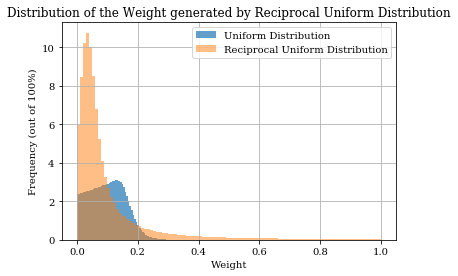

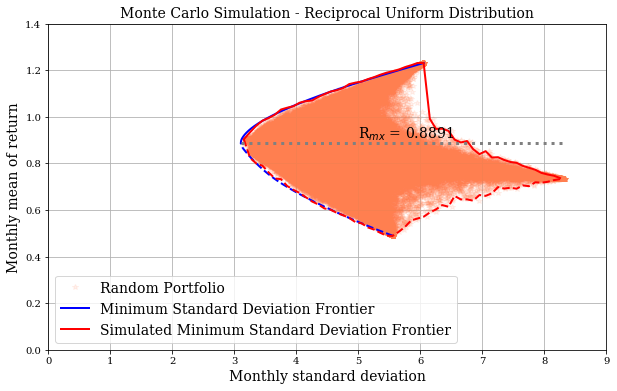

In [30]:
# Monte Carlo method
#############################################################
# random seed, keep the random number still
np.random.seed(101)

# numbers of random portfolio
n_portfolio =  int(1e6)

# generate random weight from uniform distribution
w_uniform_r = 1/np.random.rand(n_portfolio, 10).reshape(-1, 10)

w_uniform_r /= w_uniform_r.sum(axis = 1, keepdims = True)

w_uniform_r_ = w_uniform_r.reshape(-1, 1)

plt.hist(w_uniform_, bins = 100, weights = weight,
         alpha = 0.7, label ='Uniform Distribution')
plt.hist(w_uniform_r_, bins = 100, weights = weight,
         alpha = 0.5, label ='Reciprocal Uniform Distribution')

plt.title('Distribution of the Weight generated by Reciprocal Uniform Distribution')
plt.legend(loc = 'best')
plt.ylabel('Frequency (out of 100%)')
plt.xlabel('Weight')
plt.grid(True)
plt.show()
#############################################################
# calculate sigma and mu for random portfolio
Portfolios = np.dot(IndPtf.values, w_uniform_r.T)
Mean_uniform_r = Portfolios.mean(axis = 0)
Std_uniform_r = Portfolios.std(axis = 0)

#############################################################
# filter away points inside of the frontier
step = 0.1

ind_ = np.where(Std_uniform_r == min(Std_uniform_r) )
sigma = Std_uniform_r[ind_][0]
sigma_uniform_r = [sigma]
uniform_r_line_upper = [ Mean_uniform_r[ind_][0] ]
uniform_r_line_lower = [ Mean_uniform_r[ind_][0] ]

while sigma < max(Std_uniform_r):
    sigma += step
    ind = ((Std_uniform_r.reshape(-1,) >= sigma)  
               & (Std_uniform_r.reshape(-1,) < sigma + step))
    
    while not ind.any() == True and  sigma < max(Std_uniform_r):
        sigma += 0.1
        ind = ((Std_uniform_r.reshape(-1,) >= sigma) 
               & (Std_uniform_r.reshape(-1,) < sigma + step))
        
    if  ind.any() == True:
        sigma_uniform_r.append(sigma)
        uniform_r_line_upper.append(np.max(Mean_uniform_r[ ind ]))
        uniform_r_line_lower.append(np.min(Mean_uniform_r[ ind ]))
        
#############################################################   
z = 2
fig = plt.figure(figsize = (z*5, z*3))

ind = FrontierSigma.index(min(FrontierSigma))
plt.plot(Std_uniform_r, Mean_uniform_r,
         '*', color = 'coral', alpha = 0.1, label = 'Random Portfolio')

plt.plot(FrontierSigma[ind:], FrontierMeanReturn[ind:], 
         '-', lw = z, color = 'blue', label = 'Minimum Standard Deviation Frontier')
plt.plot(FrontierSigma[:ind], FrontierMeanReturn[:ind],
         '--', lw = z, color = 'blue')

plt.plot(sigma_uniform_r, uniform_r_line_upper, 
         '-', lw = z, color = 'red', label = 'Simulated Minimum Standard Deviation Frontier')
plt.plot(sigma_uniform_r, uniform_r_line_lower,
         '--', lw = z, color = 'red')

plt.plot( [FrontierSigma[ind], max(Std_uniform_r)], [FrontierMeanReturn[ind]]*2,
         ':', lw = 1.5*z, color = 'gray')
plt.text(5, FrontierMeanReturn[ind], 'R$%s$ = '%'_{mx}'\
         +str(round(FrontierMeanReturn[ind], 4)), verticalalignment='bottom', fontsize = 7*z)

plt.xlim(0,9)
plt.ylim(0,1.4)
plt.xlabel('Monthly standard deviation', fontsize = 7*z)
plt.ylabel('Monthly mean of return', fontsize = 7*z)
plt.title('Monte Carlo Simulation - Reciprocal Uniform Distribution', fontsize = 7*z)
plt.grid(True)
plt.legend(loc = 'best', fontsize = 7*z)
plt.show()